In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
import missingno as msno
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.tree import DecisionTreeRegressor
import warnings

In [2]:
data = pd.read_csv('Provisional_COVID-19_Deaths_by_Place_of_Death_and_State.csv')

In [3]:
data.shape

(21870, 15)

In [4]:
data.columns

Index(['Data As Of', 'Start Date', 'End Date', 'Group', 'Year', 'Month',
       'State', 'Place of Death', 'COVID-19 Deaths', 'Total Deaths',
       'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths', 'Footnote'],
      dtype='object')

In [5]:
data.dtypes

Data As Of                                   object
Start Date                                   object
End Date                                     object
Group                                        object
Year                                        float64
Month                                       float64
State                                        object
Place of Death                               object
COVID-19 Deaths                             float64
Total Deaths                                float64
Pneumonia Deaths                            float64
Pneumonia and COVID-19 Deaths               float64
Influenza Deaths                            float64
Pneumonia, Influenza, or COVID-19 Deaths    float64
Footnote                                     object
dtype: object

## For our experiment we will take a sample of the original dataset

In [6]:
sampled_df = data.sample(n=1500, random_state=42)

In [7]:
sampled_df.head()

Data As Of  Start Date    End Date     Group    Year  Month  \
3246  04/12/2023  11/01/2020  11/30/2020  By Month  2020.0   11.0   
8692  04/12/2023  04/01/2021  04/30/2021  By Month  2021.0    4.0   
7534  04/12/2023  08/01/2020  08/31/2020  By Month  2020.0    8.0   
5841  04/12/2023  08/01/2021  08/31/2021  By Month  2021.0    8.0   
8979  04/12/2023  08/01/2020  08/31/2020  By Month  2020.0    8.0   

                     State                        Place of Death  \
3246                Alaska  Nursing home/long term care facility   
8692                Kansas                                 Other   
7534              Illinois         Healthcare setting, inpatient   
5841  District of Columbia           Total - All Places of Death   
8979              Kentucky  Nursing home/long term care facility   

      COVID-19 Deaths  Total Deaths  Pneumonia Deaths  \
3246              NaN          45.0               NaN   
8692              NaN         117.0               NaN   
7534            283.0        2624.0             471.0   
5841             44.0         580.0              61.0   
8979             57.0         614.0              39.0   

      Pneumonia and COVID-19 Deaths  Influenza Deaths  \
3246                            0.0               0.0   
8692                            0.0               0.0   
7534                          172.0               0.0   
5841                           34.0               0.0   
8979                           13.0               NaN   

      Pneumonia, Influenza, or COVID-19 Deaths  \
3246                                       NaN   
8692                                       NaN   
7534                                     582.0   
5841                                      71.0   
8979                                      83.0   

                                               Footnote  
3246  One or more data cells have counts between 1-9...  
8692  One or more data cells have counts between 1-9...  
7534                                                NaN  
5841                                                NaN  
8979  One or more data cells have counts between 1-9...

In [33]:
for i in sampled_df.columns:
    print(sampled_df[i].nunique())

1
40
40
3
4
12
54
9
368
907
373
277
69
452
1


In [31]:
a = 'Pneumonia, Influenza, or COVID-19 Deaths'
print(sampled_df[a].min()), print(sampled_df[a].max())

0.0
61139.0


(None, None)

In [21]:
sampled_df.dtypes

Data As Of                                   object
Start Date                                   object
End Date                                     object
Group                                        object
Year                                        float64
Month                                       float64
State                                        object
Place of Death                               object
COVID-19 Deaths                             float64
Total Deaths                                float64
Pneumonia Deaths                            float64
Pneumonia and COVID-19 Deaths               float64
Influenza Deaths                            float64
Pneumonia, Influenza, or COVID-19 Deaths    float64
Footnote                                     object
dtype: object

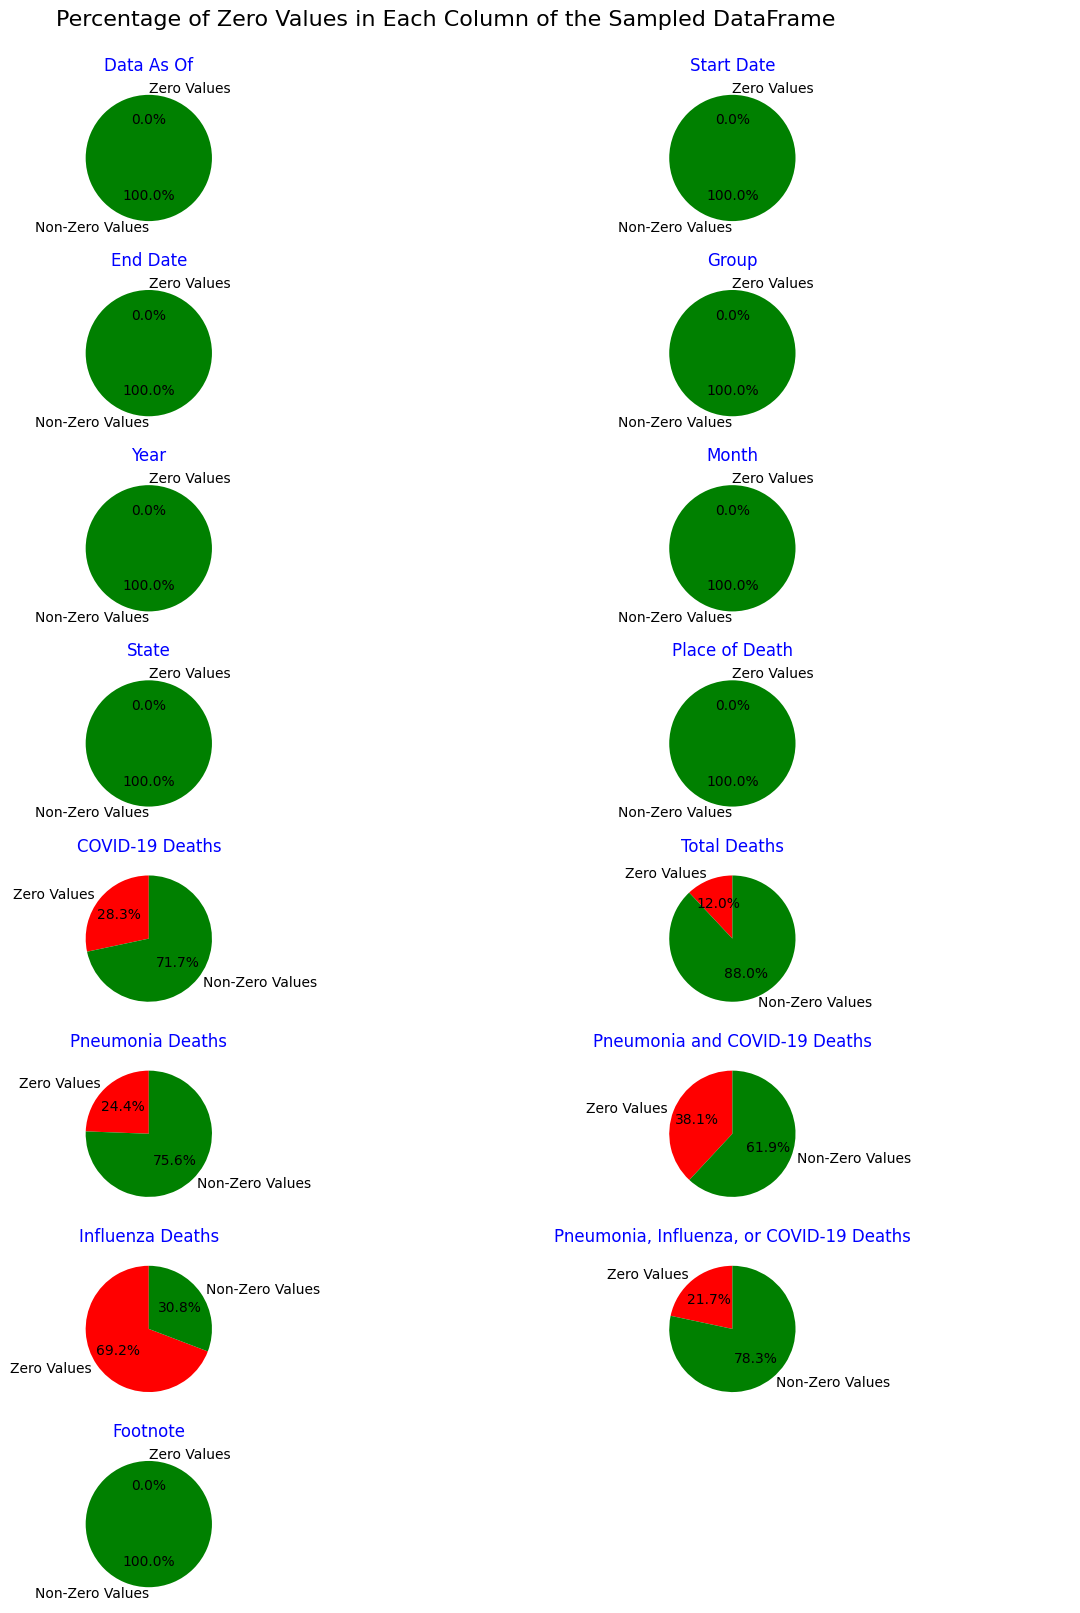

In [7]:
# Calculate the percentage of zero values in each column
percentage_zeros = (sampled_df == 0).sum() / len(sampled_df) * 100
percentage_non_zeros = 100 - percentage_zeros

# Create subplots with pie charts
num_columns = len(sampled_df.columns)
num_rows = (num_columns + 1) // 2

fig, axs = plt.subplots(num_rows, 2, figsize=(13, num_rows * 2))

# Custom colors for the column names and pie chart labels
column_name_color = 'blue'
label_colors = ['red', 'green']

for index, (column, ax) in enumerate(zip(sampled_df.columns, axs.flatten())):
    ax.pie([percentage_zeros[column], percentage_non_zeros[column]], labels=['Zero Values', 'Non-Zero Values'], autopct='%1.1f%%', startangle=90, colors=label_colors)
    ax.set_title(column, color=column_name_color)

# Adjust layout and remove unused subplots (if any)
fig.tight_layout()
for unused_ax in axs.flatten()[index+1:]:
    unused_ax.axis('off')

plt.suptitle('Percentage of Zero Values in Each Column of the Sampled DataFrame', y=1.02, fontsize=16)
plt.show()


## Since the inter column contains a large number of zeros as values, it can greatly alter the analysis and visualization.

### Reason for zero as value

#### 1.It can simply be that no mortality was experienced that particular day
#### 2.No data was collected that particular day
#### 3.False data has been entered

In [8]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 3246 to 8147
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Data As Of                                1500 non-null   object 
 1   Start Date                                1500 non-null   object 
 2   End Date                                  1500 non-null   object 
 3   Group                                     1500 non-null   object 
 4   Year                                      1469 non-null   float64
 5   Month                                     1342 non-null   float64
 6   State                                     1500 non-null   object 
 7   Place of Death                            1500 non-null   object 
 8   COVID-19 Deaths                           1190 non-null   float64
 9   Total Deaths                              1385 non-null   float64
 10  Pneumonia Deaths                 

In [9]:
sampled_df.describe()

Year        Month  COVID-19 Deaths   Total Deaths  \
count  1469.000000  1342.000000      1190.000000    1385.000000   
mean   2021.217835     6.129657       455.915126    3663.801444   
std       0.995320     3.482506      2387.121233   15582.912982   
min    2020.000000     1.000000         0.000000       0.000000   
25%    2020.000000     3.000000         0.000000      82.000000   
50%    2021.000000     6.000000        23.000000     412.000000   
75%    2022.000000     9.000000       133.000000    1806.000000   
max    2023.000000    12.000000     48786.000000  271496.000000   

       Pneumonia Deaths  Pneumonia and COVID-19 Deaths  Influenza Deaths  \
count       1180.000000                    1104.000000       1174.000000   
mean         437.749153                     249.687500          6.645656   
std         2231.012284                    1468.504967         42.787333   
min            0.000000                       0.000000          0.000000   
25%            0.000000                       0.000000          0.000000   
50%           28.000000                       0.000000          0.000000   
75%          158.250000                      55.000000          0.000000   
max        41390.000000                   29152.000000       1021.000000   

       Pneumonia, Influenza, or COVID-19 Deaths  
count                               1251.000000  
mean                                 632.165468  
std                                 3128.985615  
min                                    0.000000  
25%                                    0.000000  
50%                                   41.000000  
75%                                  209.500000  
max                                61139.000000

In [10]:
# Checking the dimensions
print(f"The Dimensions are: {sampled_df.shape}")

The Dimensions are: (1500, 15)


# Data Preprocessing

In [11]:
sampled_df.sort_values(by=['Start Date', 'End Date'], inplace=True)

In [12]:
sampled_df.reset_index(drop=True, inplace=True)

In [13]:
sampled_df.head()

Data As Of  Start Date    End Date     Group    Year  Month  \
0  04/12/2023  01/01/2020  01/31/2020  By Month  2020.0    1.0   
1  04/12/2023  01/01/2020  01/31/2020  By Month  2020.0    1.0   
2  04/12/2023  01/01/2020  01/31/2020  By Month  2020.0    1.0   
3  04/12/2023  01/01/2020  01/31/2020  By Month  2020.0    1.0   
4  04/12/2023  01/01/2020  01/31/2020  By Month  2020.0    1.0   

                  State                                    Place of Death  \
0  District of Columbia                     Healthcare setting, inpatient   
1  District of Columbia               Healthcare setting, dead on arrival   
2          North Dakota              Nursing home/long term care facility   
3               Vermont  Healthcare setting, outpatient or emergency room   
4               Wyoming  Healthcare setting, outpatient or emergency room   

   COVID-19 Deaths  Total Deaths  Pneumonia Deaths  \
0              0.0         314.0              35.0   
1              0.0           0.0               0.0   
2              0.0         230.0              11.0   
3              0.0          18.0               0.0   
4              0.0          34.0               0.0   

   Pneumonia and COVID-19 Deaths  Influenza Deaths  \
0                            0.0               NaN   
1                            0.0               0.0   
2                            0.0               0.0   
3                            0.0               NaN   
4                            0.0               NaN   

   Pneumonia, Influenza, or COVID-19 Deaths  \
0                                      37.0   
1                                       0.0   
2                                      11.0   
3                                       NaN   
4                                       NaN   

                                            Footnote  
0  One or more data cells have counts between 1-9...  
1                                                NaN  
2                                                NaN  
3  One or more data cells have counts between 1-9...  
4  One or more data cells have counts between 1-9...

In [14]:
sampled_df.duplicated().sum()

0

### Dropping unnecessary columns

In [15]:
sampled_df['Data As Of'].unique()

array(['04/12/2023'], dtype=object)

#### Since the entire column 'Data As Of' contains the exact same values for all the rows. It can be assumed that the column cannot contribute to the analysis and can be dropped

In [16]:
sampled_df['Footnote'].unique()

array(['One or more data cells have counts between 1-9 and have been suppressed in accordance with NCHS confidentiality standards.',
       nan], dtype=object)

#### Since the entire values of 'Footnote' column is a confidentiality statement. It is removed.

In [17]:
sampled_df.drop(['Footnote','Data As Of'],axis=1,inplace=True)

In [18]:
sampled_df.columns

Index(['Start Date', 'End Date', 'Group', 'Year', 'Month', 'State',
       'Place of Death', 'COVID-19 Deaths', 'Total Deaths', 'Pneumonia Deaths',
       'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths'],
      dtype='object')

# Missing Values

#### Missing values are data points that are absent or not recorded in a dataset. They are often represented as NaN(Not a Number) or null values.

#### Reasons for missing values

#### 1.Data Entry Errors
#### 2.Non-response or incompleted data
#### 3.Data aggregation/merging
#### 4.Data Censoring or truncating
#### 5.System failures

In [19]:
sampled_df.isnull().sum()

Start Date                                    0
End Date                                      0
Group                                         0
Year                                         31
Month                                       158
State                                         0
Place of Death                                0
COVID-19 Deaths                             310
Total Deaths                                115
Pneumonia Deaths                            320
Pneumonia and COVID-19 Deaths               396
Influenza Deaths                            326
Pneumonia, Influenza, or COVID-19 Deaths    249
dtype: int64

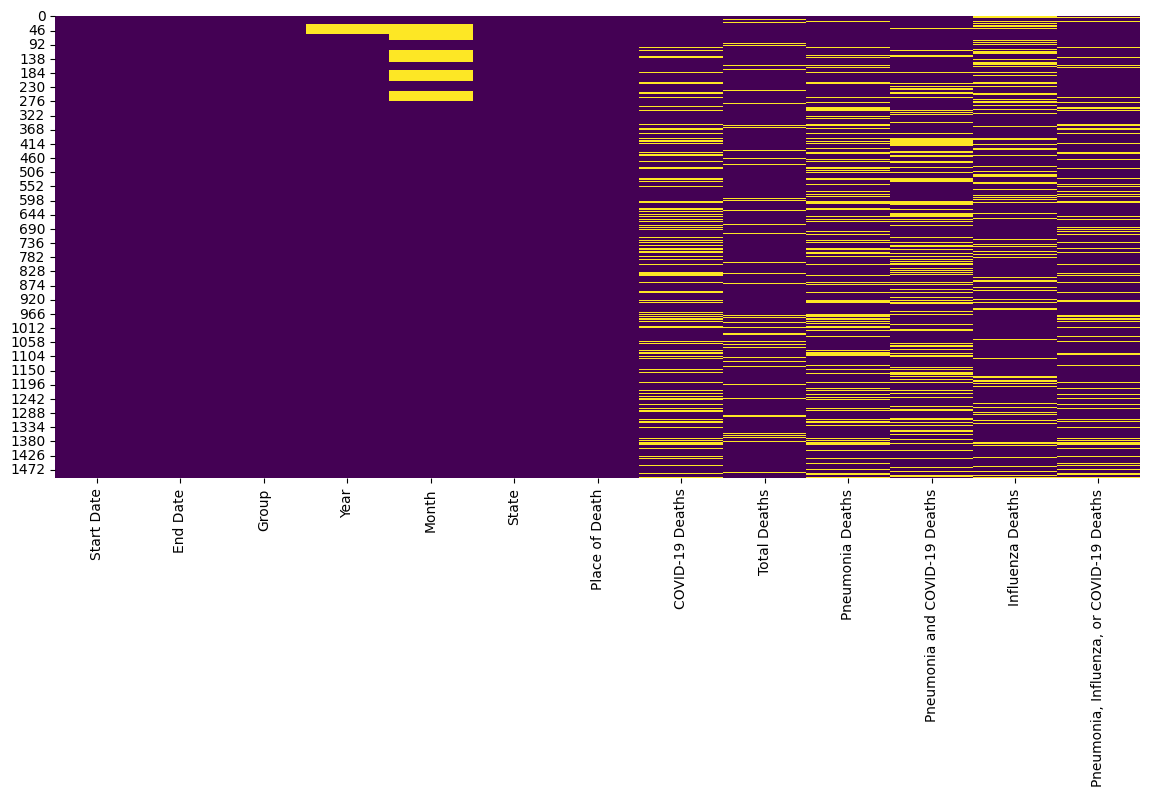

In [20]:
#set the size of the plot
matplotlib.rcParams['figure.figsize'] = (14,6)

sns.heatmap(sampled_df.isnull(),cbar=False,cmap='viridis')
plt.show()

In [21]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Create a binary matrix indicating the presence of missing values
missing_data_binary = sampled_df.isnull().astype(int)

fig = go.Figure(data=go.Heatmap(
    z=missing_data_binary,
    colorscale='Viridis',  # You can choose any colorscale you prefer
    showscale=False
))

fig.update_layout(
    title='Missing Data Heatmap',
    xaxis_title='Columns',
    yaxis_title='Rows',
    xaxis=dict(tickmode='array', tickvals=list(range(len(sampled_df.columns))), ticktext=sampled_df.columns),
    yaxis=dict(autorange='reversed')
)

fig.show()


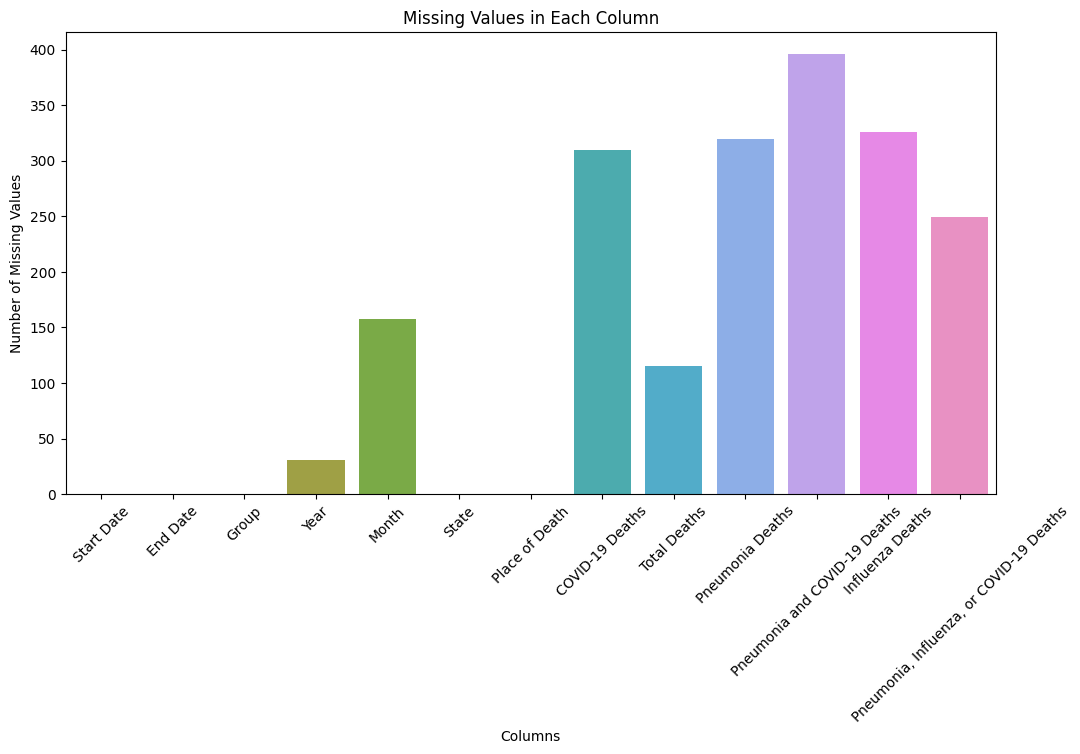

In [22]:
missing = sampled_df.isnull().sum()
plt.figure(figsize=(12,6))
sns.barplot(x=missing.index, y=missing)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()

## Converting data-types and filling missing values

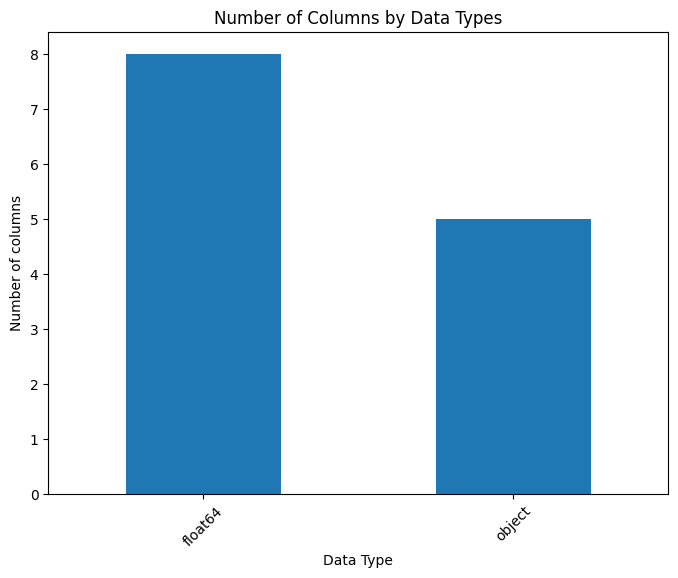

In [23]:
dtype_count = sampled_df.dtypes.value_counts()

#bar plot
plt.figure(figsize=(8,6))
dtype_count.plot(kind='bar')
plt.xlabel('Data Type')
plt.ylabel('Number of columns')
plt.title('Number of Columns by Data Types')
plt.xticks(rotation=45)
plt.show()

### Converting float values to integer and using median to fill missing values

#### Median is used as it is more robust towards outliers in the data

In [24]:
# List of columns to convert
columns_to_convert = [
    'Year',
    'Month',
    'COVID-19 Deaths',
    'Total Deaths',
    'Pneumonia Deaths',
    'Pneumonia and COVID-19 Deaths',
    'Influenza Deaths',
    'Pneumonia, Influenza, or COVID-19 Deaths'
]

# Convert each column to an integer data type
for column in columns_to_convert:
    sampled_df[column] = sampled_df[column].fillna(sampled_df[column].median()).astype(int)


In [25]:
sampled_df.dtypes

Start Date                                  object
End Date                                    object
Group                                       object
Year                                         int32
Month                                        int32
State                                       object
Place of Death                              object
COVID-19 Deaths                              int32
Total Deaths                                 int32
Pneumonia Deaths                             int32
Pneumonia and COVID-19 Deaths                int32
Influenza Deaths                             int32
Pneumonia, Influenza, or COVID-19 Deaths     int32
dtype: object

In [26]:
sampled_df.isnull().sum().sum()

0

In [27]:
sampled_df.describe()

Year        Month  COVID-19 Deaths   Total Deaths  \
count  1500.000000  1500.000000      1500.000000    1500.000000   
mean   2021.213333     6.116000       366.446000    3414.496667   
std       0.985462     3.294103      2133.225709   14998.234677   
min    2020.000000     1.000000         0.000000       0.000000   
25%    2020.000000     3.000000         0.000000     104.000000   
50%    2021.000000     6.000000        23.000000     412.000000   
75%    2022.000000     9.000000        83.000000    1645.750000   
max    2023.000000    12.000000     48786.000000  271496.000000   

       Pneumonia Deaths  Pneumonia and COVID-19 Deaths  Influenza Deaths  \
count       1500.000000                    1500.000000       1500.000000   
mean         350.336000                     183.770000          5.201333   
std         1985.712451                    1264.488424         37.948960   
min            0.000000                       0.000000          0.000000   
25%           10.000000                       0.000000          0.000000   
50%           28.000000                       0.000000          0.000000   
75%           89.000000                      26.000000          0.000000   
max        41390.000000                   29152.000000       1021.000000   

       Pneumonia, Influenza, or COVID-19 Deaths  
count                               1500.000000  
mean                                 534.032000  
std                                 2865.772238  
min                                    0.000000  
25%                                   12.000000  
50%                                   41.000000  
75%                                  147.000000  
max                                61139.000000

# Outlier Detection

## The following plots are used to check if the data contains any outliers

##### Boxplot

In [28]:
#box plot
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])
sampled_df.plot(kind='box',subplots=True,layout= (3,3),sharex=True)
plt.show()

NameError: name 'df' is not defined

##### Density plots

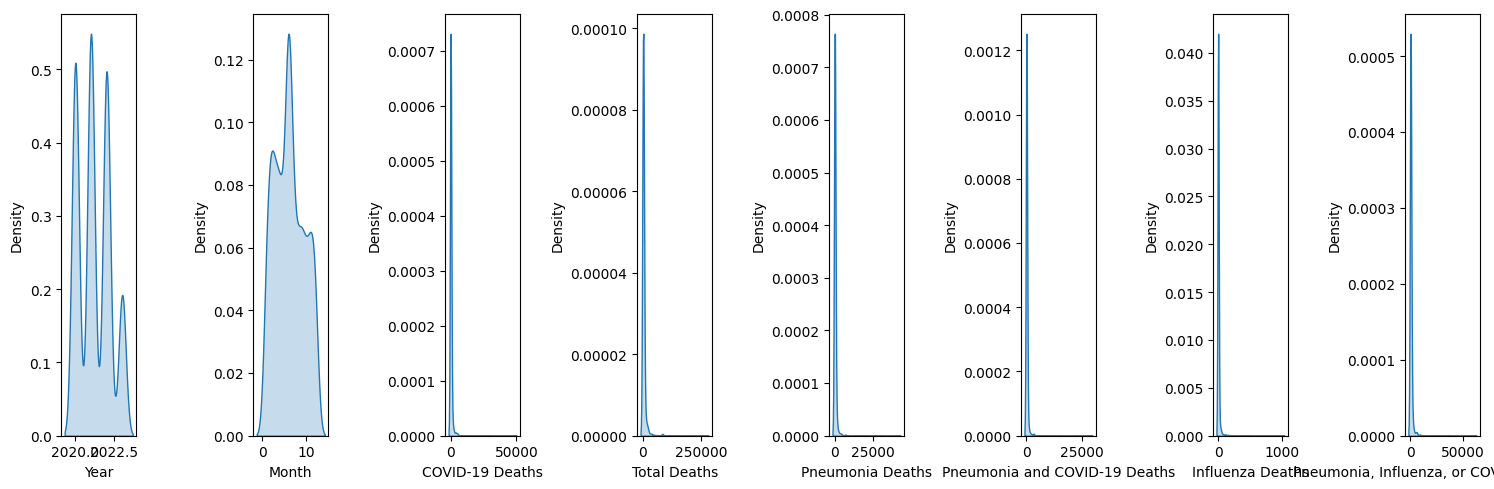

In [29]:
numeric_columns = [
    'Year',
    'Month',
    'COVID-19 Deaths',
    'Total Deaths',
    'Pneumonia Deaths',
    'Pneumonia and COVID-19 Deaths',
    'Influenza Deaths',
    'Pneumonia, Influenza, or COVID-19 Deaths'
]
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(15, 5))

for i, column in enumerate(numeric_columns):
    sns.kdeplot(data=sampled_df[column], ax=axes[i], fill=True)
    #axes.set_title(f'Density Plot of {column}')
plt.tight_layout()
plt.show()

##### Histogram plots

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=len(numeric_columns), subplot_titles=numeric_columns, column_widths=[0.3]*len(numeric_columns))

for i, column in enumerate(numeric_columns):
    fig.add_trace(go.Histogram(x=sampled_df[column], nbinsx=30), row=1, col=i + 1)

fig.update_layout(
    #title='Histograms of Numeric Columns',
    width=1002,
    height=500,
    margin=dict(l=10, r=10, t=175, b=10),
    showlegend=False
)

for annotation in fig['layout']['annotations']:
    annotation['textangle'] = 45

fig.show()


## All the 3 distribution plots indicates the presence of outliers and several extreme outliers in the data

In [31]:
sampled_df.skew(numeric_only=True)

Year                                         0.253911
Month                                        0.189407
COVID-19 Deaths                             13.553600
Total Deaths                                10.888001
Pneumonia Deaths                            12.573856
Pneumonia and COVID-19 Deaths               14.859882
Influenza Deaths                            17.039698
Pneumonia, Influenza, or COVID-19 Deaths    12.269375
dtype: float64

### From the visualization and analysis, it is clear that the data is and several outliers and extreme outliers exists in the dataset.


# Treating outliers

In [32]:
sampled_df['Influenza Deaths'].describe()

count    1500.000000
mean        5.201333
std        37.948960
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1021.000000
Name: Influenza Deaths, dtype: float64

In [33]:
IQR = sampled_df['Influenza Deaths'].quantile(0.75)-sampled_df['Influenza Deaths'].quantile(0.25)
IQR

0.0

In [34]:
lower_bridge = sampled_df['Influenza Deaths'].quantile(0.25) - (IQR * 3)
upper_bridge = sampled_df['Influenza Deaths'].quantile(0.75)+(IQR*3)
print(f"Lower boundary: {lower_bridge}")
print(f"Upper boundary: {upper_bridge}\n")

Lower boundary: 0.0
Upper boundary: 0.0



In [35]:
import numpy as np

def modified_z_score(column_data):
    median_value = np.median(column_data)
    mad = np.median(np.abs(column_data - median_value))
    modified_z_scores = 0.6745 * (column_data - median_value) / mad
    return modified_z_scores

column = 'Influenza Deaths'
threshold = 3.5  # Adjust the threshold value based on your requirements

# Calculate Modified Z-score for the 'Influenza Deaths' column
influenza_z_scores = modified_z_score(sampled_df[column])

# Identify the outliers
outliers = np.where(np.abs(influenza_z_scores) > threshold)

print(f"Outliers in {column}: {sampled_df.iloc[outliers][column].values}")


Outliers in Influenza Deaths: [  12   10   15  387   56   75   32   16  466   48   30   32   13  124
   13   50   38   17   54   42   18  405   31  125  160  213   46  113
   12   10  109 1021   14   16  164   56   33   10   27   24   16   13
   11   11   13   22   64   19   88  150   18   18   77   62  196  162
   40   19   31   94   13   15   16   20   21   27   44   10   17   48
   13   13   37   10   36   10   19   36   73    1   10   12   15   39
   18   10   32   22   10   10   93   19   13   11   15   23   12   70
    2   22    2   36    4    7   39    1   13   23    1   12   12   22
   15   27   50   23    9   28   22   87   11   52   11   38   38  117
   18   35  196   17   18   15   11  430   43  121]


In [36]:
numerical_columns = [
    'COVID-19 Deaths',
    'Total Deaths',
    'Pneumonia Deaths',
    'Pneumonia and COVID-19 Deaths',
    'Pneumonia, Influenza, or COVID-19 Deaths'
]
for column in numerical_columns:
    IQR = sampled_df[column].quantile(0.75)-sampled_df[column].quantile(0.25)
    
    lower_bridge = sampled_df[column].quantile(0.25) - (IQR * 3)
    upper_bridge = sampled_df[column].quantile(0.75)+(IQR*3)
    
    print(f"Column : {column}")
    print(f"Lower boundary: {lower_bridge}")
    print(f"Upper boundary: {upper_bridge}\n")    
    #sampled_df.loc[sampled_df[column] > upper_bridge, column] = upper_bridge   

Column : COVID-19 Deaths
Lower boundary: -249.0
Upper boundary: 332.0

Column : Total Deaths
Lower boundary: -4521.25
Upper boundary: 6271.0

Column : Pneumonia Deaths
Lower boundary: -227.0
Upper boundary: 326.0

Column : Pneumonia and COVID-19 Deaths
Lower boundary: -78.0
Upper boundary: 104.0

Column : Pneumonia, Influenza, or COVID-19 Deaths
Lower boundary: -393.0
Upper boundary: 552.0



In [37]:
sampled_df['Pneumonia and COVID-19 Deaths'].max()

29152

In [38]:
sampled_df.to_csv('final_df.csv',index=False)

In [39]:
df = pd.read_csv('final_df.csv')
df

Start Date    End Date     Group  Year  Month                 State  \
0     01/01/2020  01/31/2020  By Month  2020      1  District of Columbia   
1     01/01/2020  01/31/2020  By Month  2020      1  District of Columbia   
2     01/01/2020  01/31/2020  By Month  2020      1          North Dakota   
3     01/01/2020  01/31/2020  By Month  2020      1               Vermont   
4     01/01/2020  01/31/2020  By Month  2020      1               Wyoming   
...          ...         ...       ...   ...    ...                   ...   
1495  12/01/2022  12/31/2022  By Month  2022     12         United States   
1496  12/01/2022  12/31/2022  By Month  2022     12              Arkansas   
1497  12/01/2022  12/31/2022  By Month  2022     12               Vermont   
1498  12/01/2022  12/31/2022  By Month  2022     12              Oklahoma   
1499  12/01/2022  12/31/2022  By Month  2022     12               Indiana   

                                        Place of Death  COVID-19 Deaths  \
0                        Healthcare setting, inpatient                0   
1                  Healthcare setting, dead on arrival                0   
2                 Nursing home/long term care facility                0   
3     Healthcare setting, outpatient or emergency room                0   
4     Healthcare setting, outpatient or emergency room                0   
...                                                ...              ...   
1495              Nursing home/long term care facility             2732   
1496                     Healthcare setting, inpatient               60   
1497  Healthcare setting, outpatient or emergency room               23   
1498                       Total - All Places of Death              222   
1499  Healthcare setting, outpatient or emergency room               13   

      Total Deaths  Pneumonia Deaths  Pneumonia and COVID-19 Deaths  \
0              314                35                              0   
1                0                 0                              0   
2              230                11                              0   
3               18                 0                              0   
4               34                 0                              0   
...            ...               ...                            ...   
1495         47307              1865                            466   
1496          1019               212                             34   
1497            28                28                              0   
1498          4216               357                             66   
1499           372                20                              0   

      Influenza Deaths  Pneumonia, Influenza, or COVID-19 Deaths  
0                    0                                        37  
1                    0                                         0  
2                    0                                        11  
3                    0                                        41  
4                    0                                        41  
...                ...                                       ...  
1495               430                                      4535  
1496                43                                       278  
1497                 0                                        41  
1498               121                                       625  
1499                 0                                        36  

[1500 rows x 13 columns]

In [40]:
df['State'].nunique()

54

## Which month contributed to the most deaths

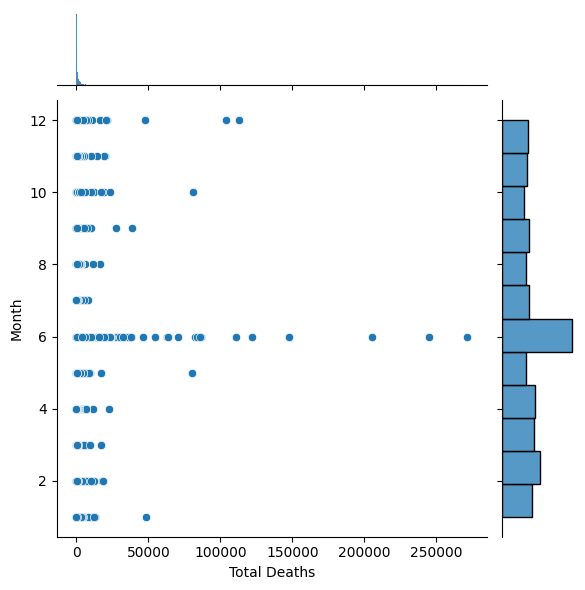

In [41]:
sns.jointplot(x='Total Deaths', y = 'Month',data=df,kind='scatter')

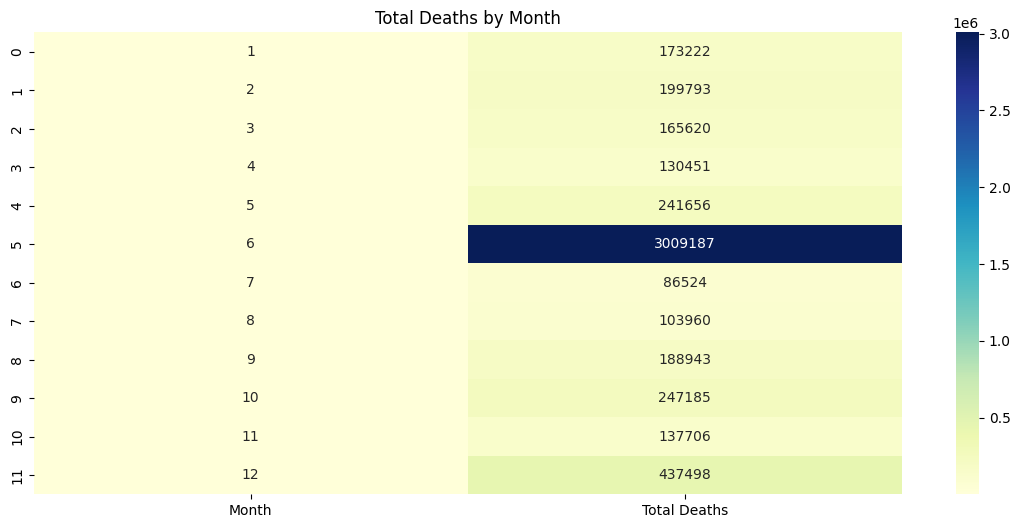

In [42]:
tot_deaths = df.pivot_table(values='Total Deaths',index='Month',aggfunc=np.sum)
tot_deaths.reset_index(inplace=True)

sns.heatmap(tot_deaths[['Month','Total Deaths']], annot=True,fmt='.0f', cmap='YlGnBu')
plt.title("Total Deaths by Month")
plt.show()

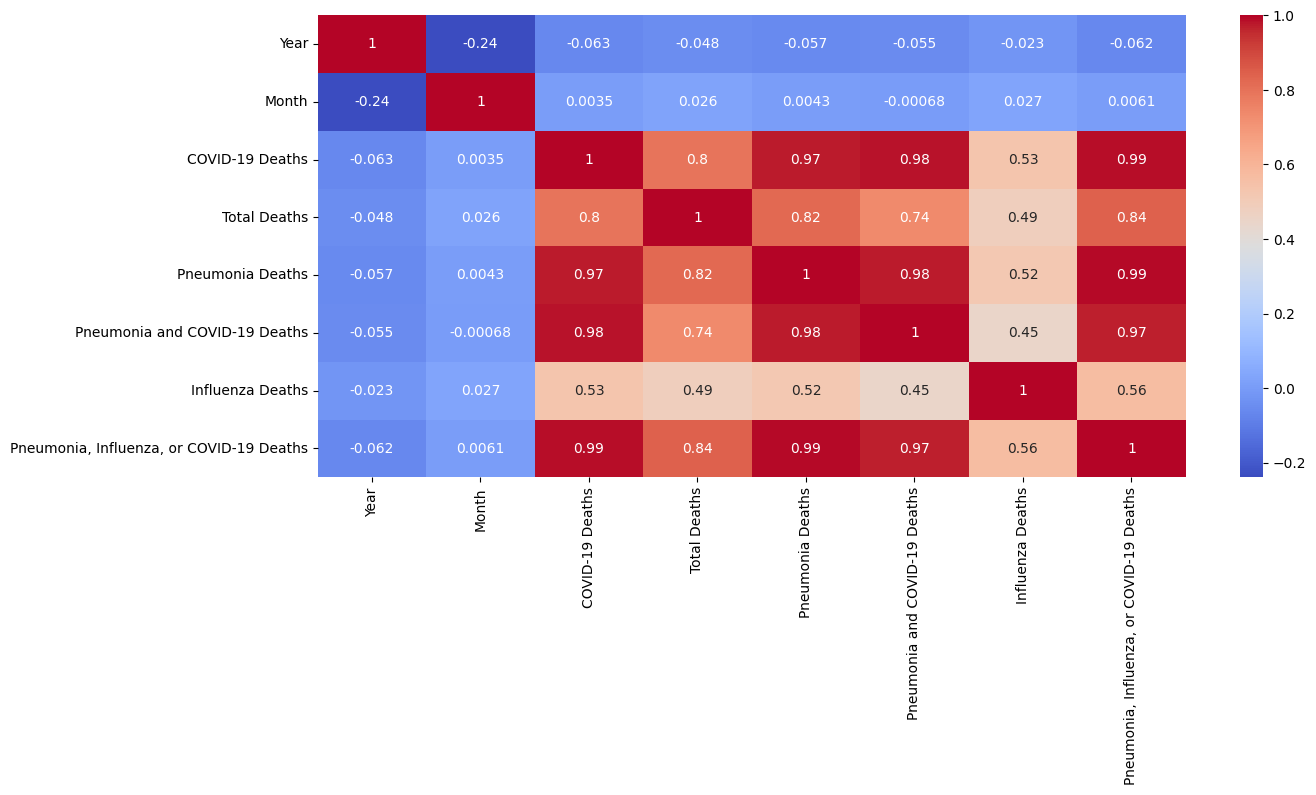

In [43]:
sns.heatmap(df.corr(method='pearson',numeric_only=True),cmap='coolwarm',annot=True)
plt.show()

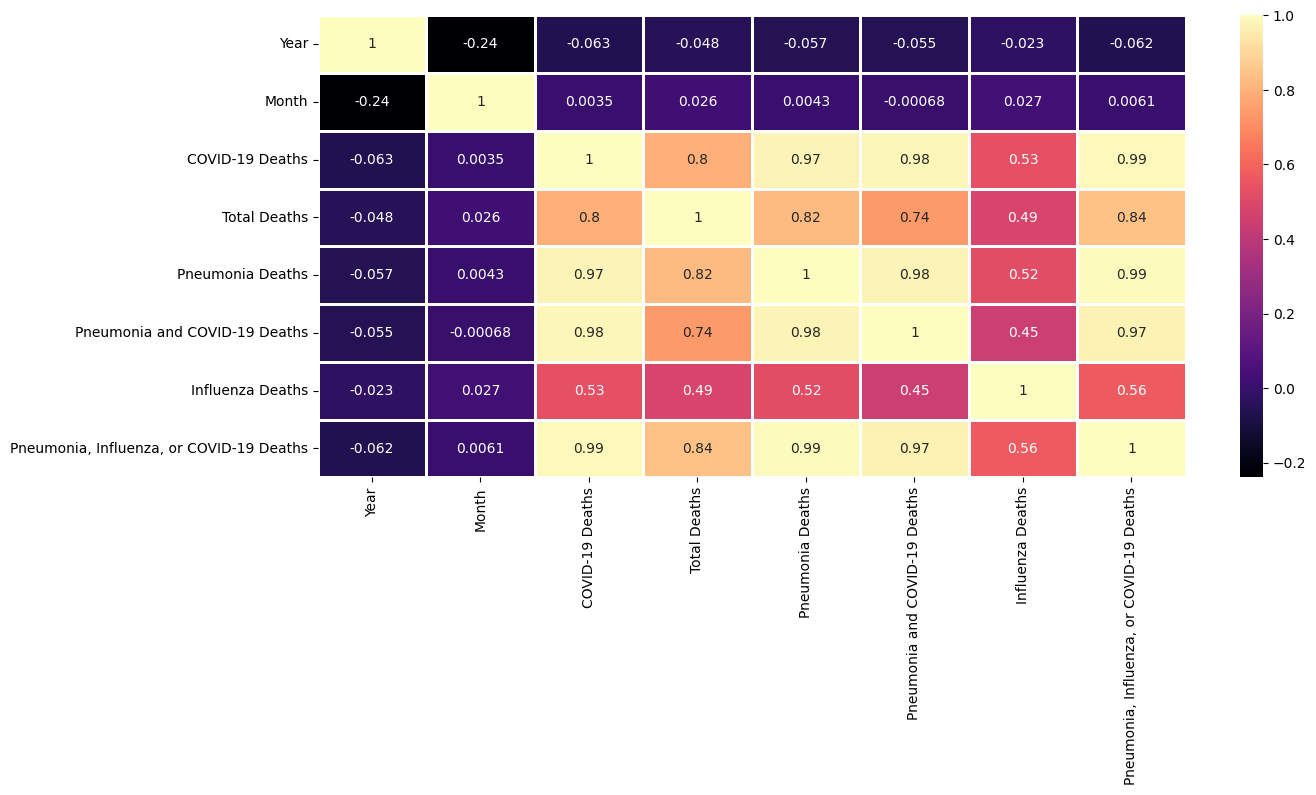

In [44]:
sns.heatmap(df.corr(method='pearson', numeric_only=True),cmap='magma',linecolor='white',linewidths=1,annot=True)
plt.show()

## Correlation of different kinds of deaths recorded

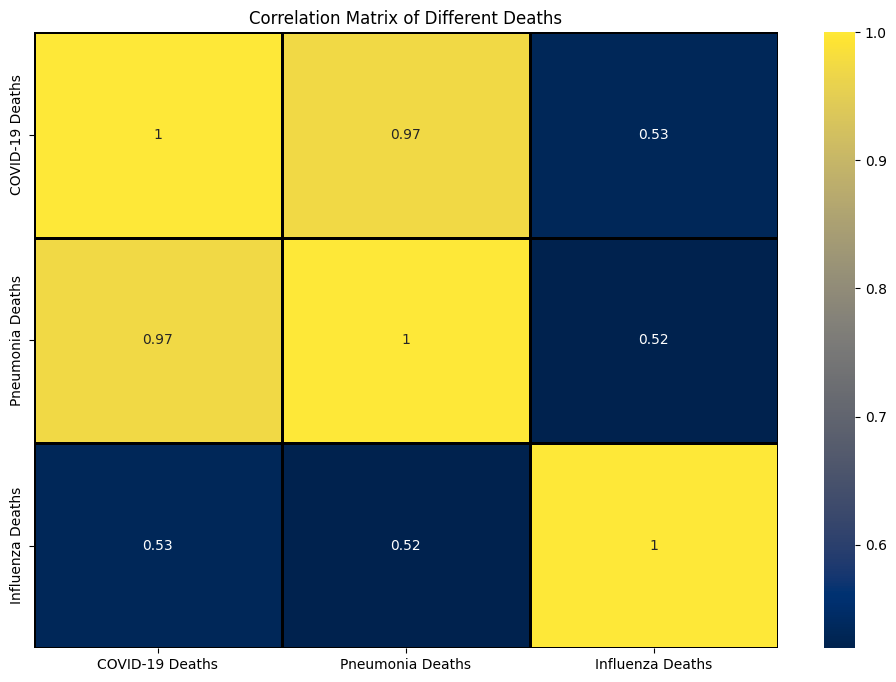

In [45]:
#columns to include
correlation_columns = [
    'COVID-19 Deaths',
    'Pneumonia Deaths',
    'Influenza Deaths',
]
#correlation
corr_mat = df[correlation_columns].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat,cmap='cividis',linecolor='black',linewidths=1,annot=True)
plt.title('Correlation Matrix of Different Deaths')
plt.show()

## Relationship between different States and their total deaths from various causes

### The y-axis represents how different the states (clusters) are from each other based on the death counts for various causes. A higher distance on the y-axis indicates that the clusters being merged are more dissimilar, while a lower distance means they are more similar.

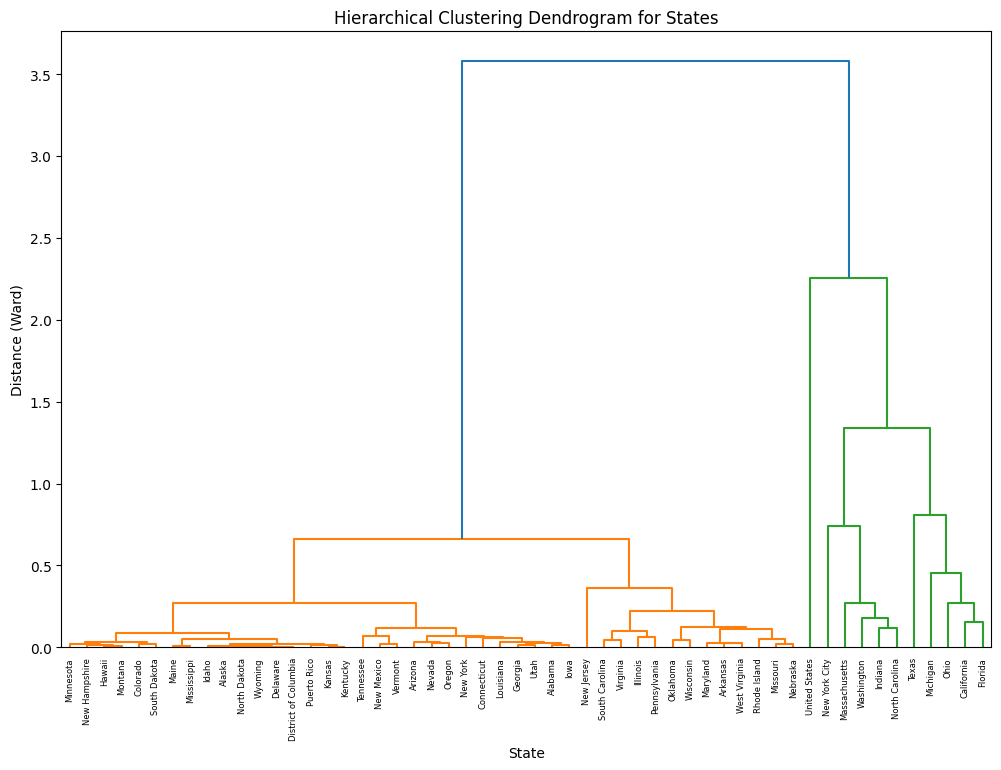

In [46]:
statewise_sum = df.pivot_table(values=['COVID-19 Deaths', 'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
                                       'Pneumonia, Influenza, or COVID-19 Deaths', 'Total Deaths'], index='State',aggfunc=np.sum)

scaler = MinMaxScaler()
statewise_normalised = pd.DataFrame(scaler.fit_transform(statewise_sum), index=statewise_sum.index, 
                                    columns=statewise_sum.columns)

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(statewise_normalised, method='ward')

# Create the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=statewise_normalised.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram for States")
plt.xlabel("State")
plt.ylabel("Distance (Ward)")

# Show the plot
plt.show()


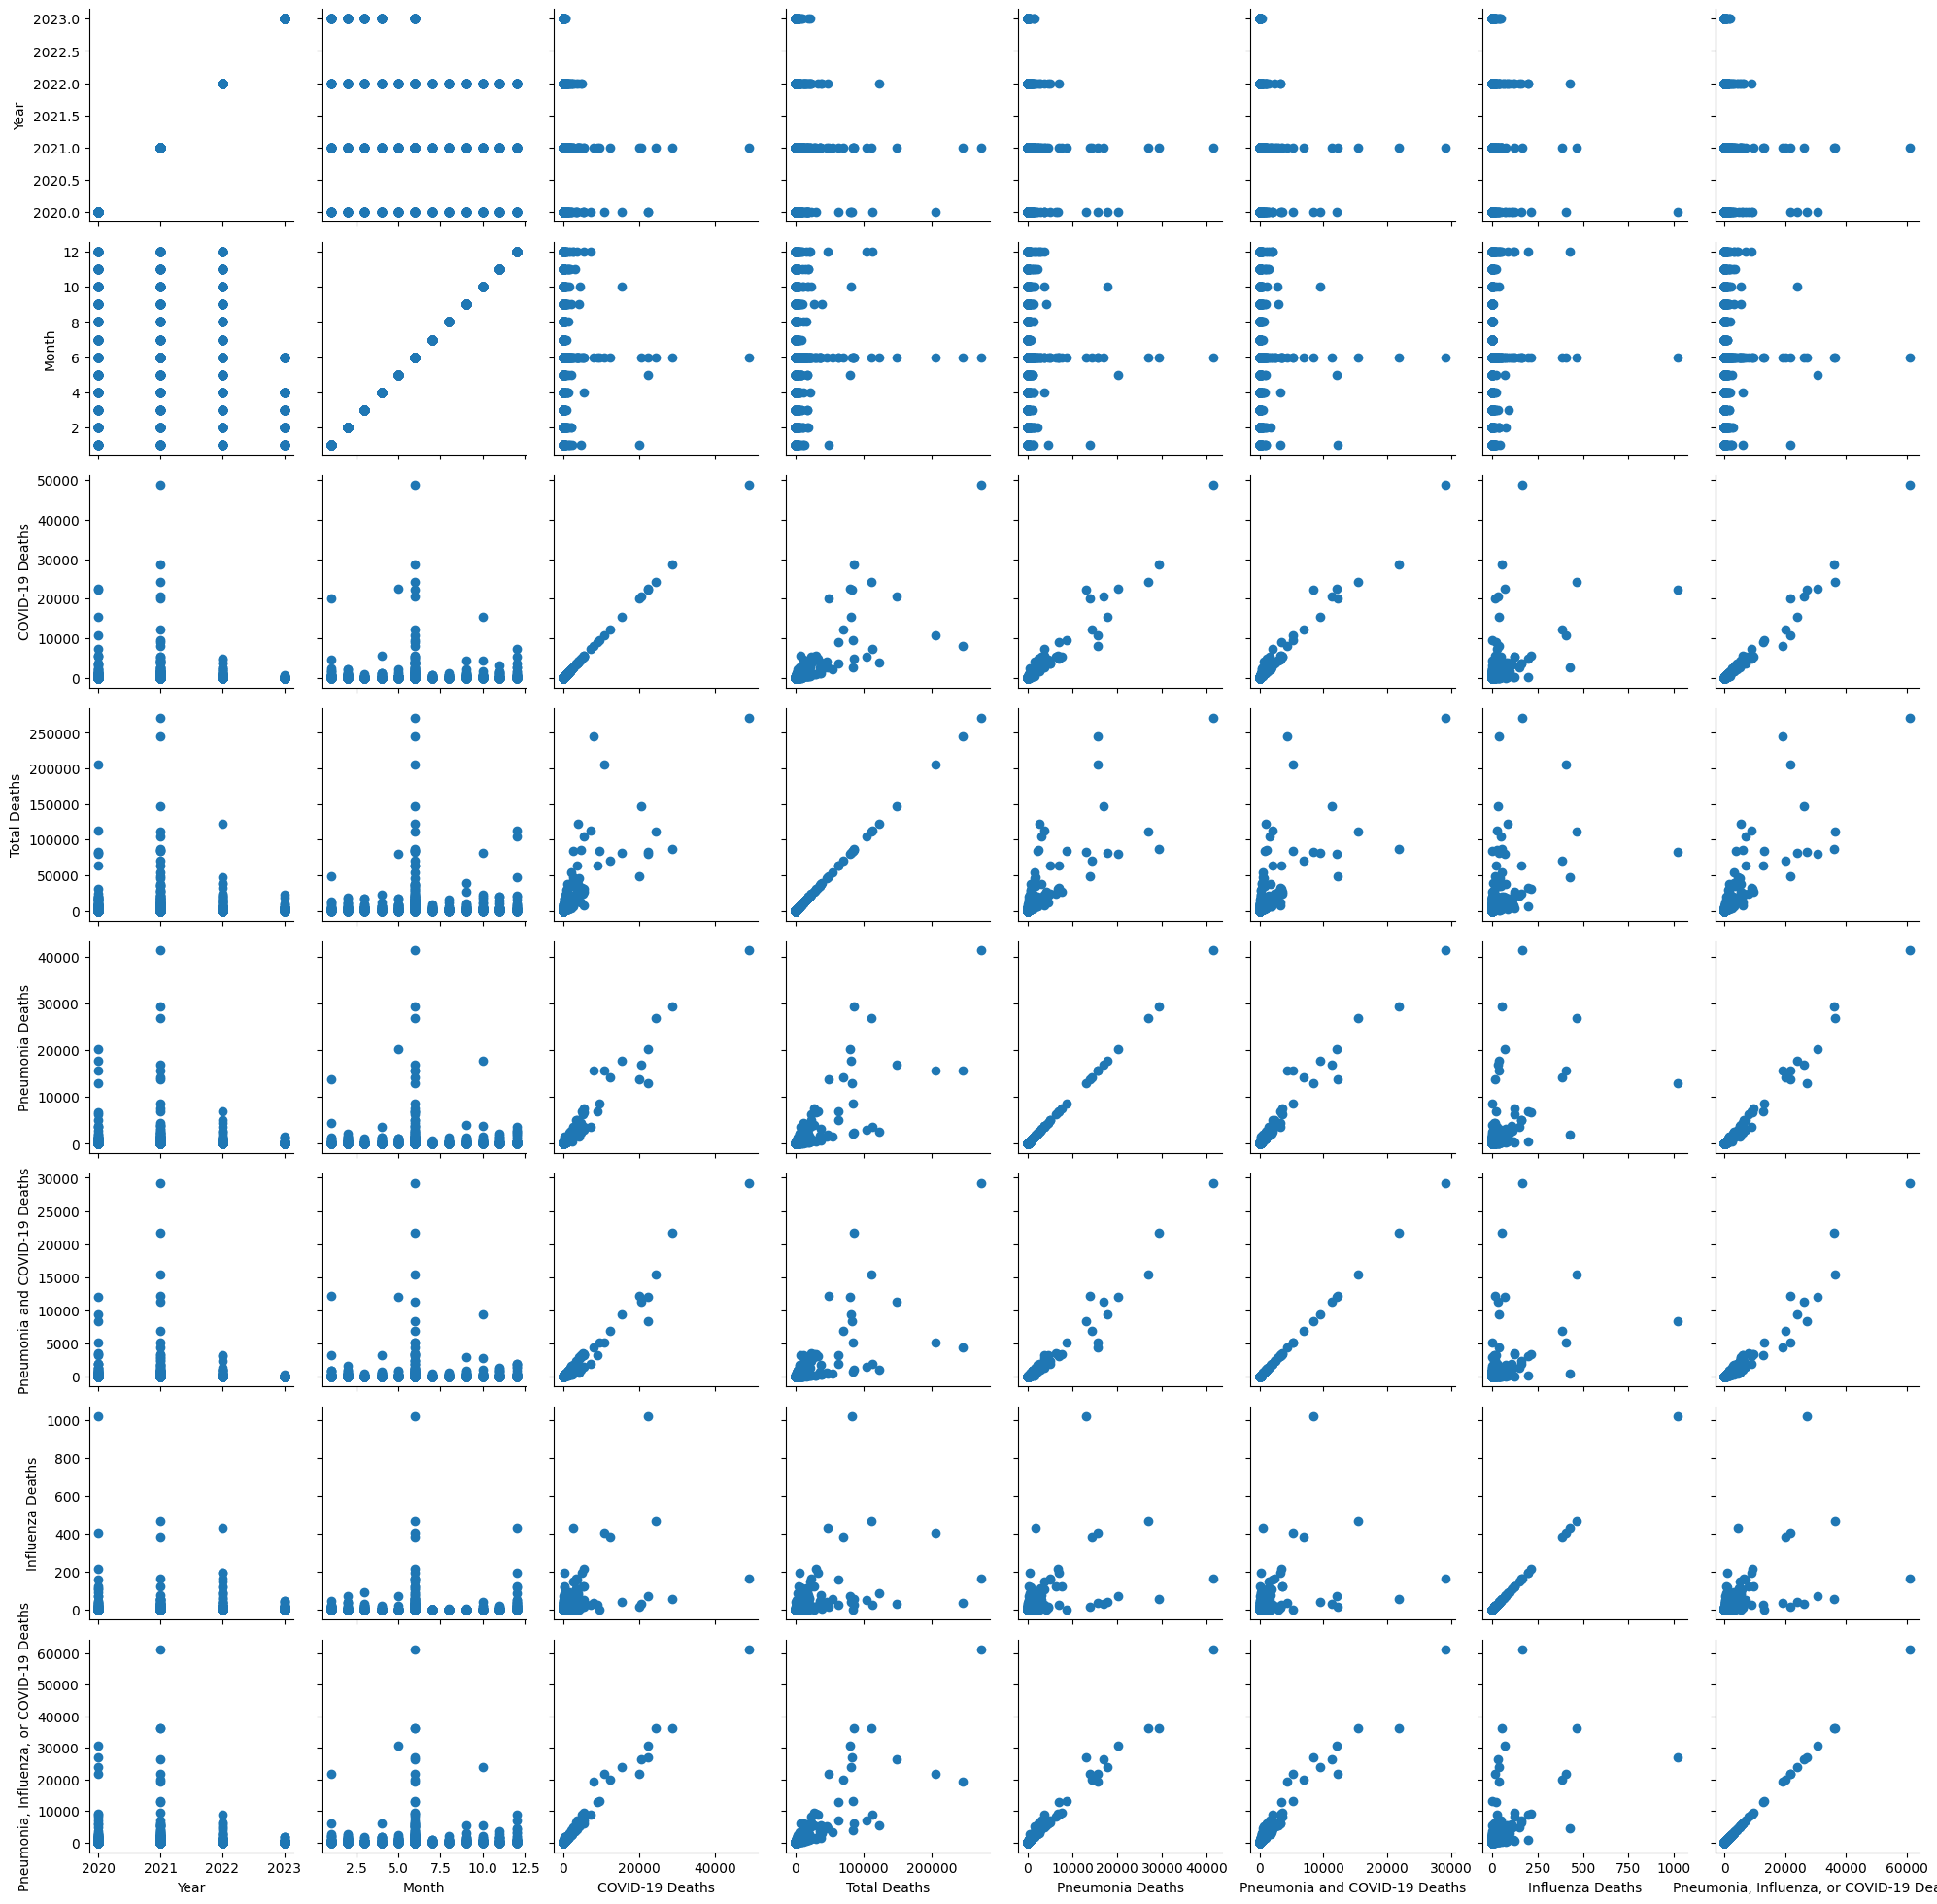

In [47]:
g = sns.PairGrid(df)
g.map(plt.scatter)

In [48]:
statewise = pd.pivot_table(df, values=['COVID-19 Deaths', 'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths', 'Pneumonia, Influenza, or COVID-19 Deaths', 'Total Deaths'], index='State', aggfunc=np.sum)
statewise = statewise.sort_values(by=['Total Deaths'], ascending=False)

### We can notice that United states had a total of 1133188 deaths across the country from COVID-19, Influenza & Pneumonia

### Texas has the highest mortality rate of 447455.
### District of Columnbia has the lowest mortality rate of 3374

In [49]:
statewise.style.background_gradient(cmap='cubehelix')

# Top 10 cities with most deaths

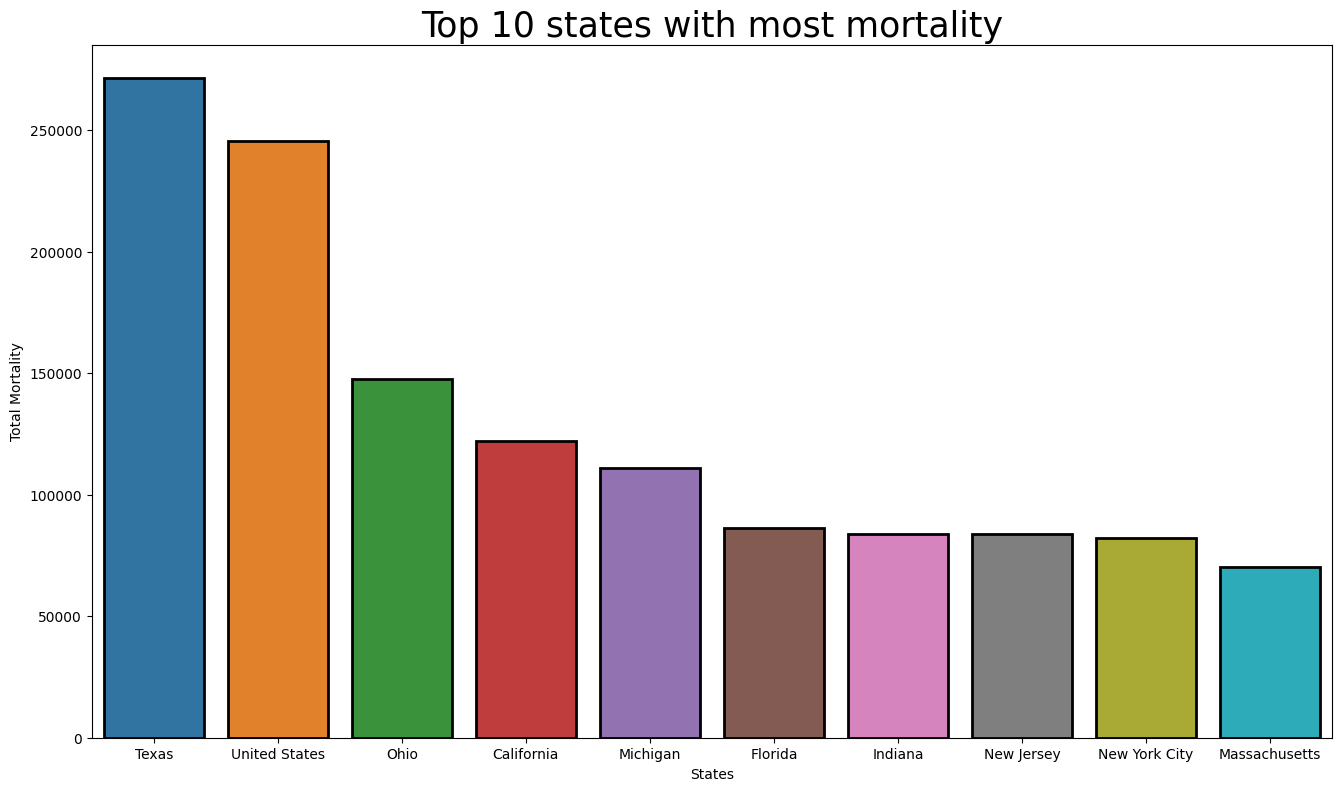

In [50]:
top_10_cities = df.groupby(by='State').max()[['COVID-19 Deaths', 'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths', 'Pneumonia, Influenza, or COVID-19 Deaths', 'Total Deaths','Start Date']].sort_values(by=['Total Deaths'], ascending = False).reset_index()
fig = plt.figure(figsize = (16,9))
plt.title("Top 10 states with most mortality", size = 25)
ax = sns.barplot(data=top_10_cities.iloc[:10], y = "Total Deaths", x="State", linewidth=2,edgecolor = 'black')
plt.xlabel('States')
plt.ylabel('Total Mortality')
plt.show()

In [51]:
sampled_df.columns

Index(['Start Date', 'End Date', 'Group', 'Year', 'Month', 'State',
       'Place of Death', 'COVID-19 Deaths', 'Total Deaths', 'Pneumonia Deaths',
       'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths'],
      dtype='object')

## Growth/Trend of different kinds of deaths

#### Hover over the plot to check values

### It is noticable that 'Covid 19' has been the biggest factor of mortality out of the 3 types of deaths recorded.
### We can also notice that 'Covid 19' leads in total number of deaths from 2020 up untill 2023

In [52]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

grouped_start_data = df.groupby('Start Date').agg({
    'COVID-19 Deaths': 'sum',
    'Pneumonia Deaths': 'sum',
    'Influenza Deaths': 'sum'
})

grouped_end_data = df.groupby('End Date').agg({
    'COVID-19 Deaths': 'sum',
    'Pneumonia Deaths': 'sum',
    'Influenza Deaths': 'sum'
})

cumulative_df_start = grouped_start_data.cumsum()
cumulative_df_end = grouped_end_data.cumsum()

cumulative_df_start.reset_index(inplace = True)
cumulative_df_end.reset_index(inplace = True)

melted_df_start = cumulative_df_start.melt(id_vars='Start Date', var_name = 'Death Type', value_name = 'Cumulative Deaths')
melted_df_end = cumulative_df_end.melt(id_vars='End Date', var_name = 'Death Type', value_name = 'Cumulative Deaths')

fig = make_subplots(rows=1, cols=2, subplot_titles=('Start Date', 'End Date'))

for death_type in melted_df_start['Death Type'].unique():
    fig.add_trace(
    go.Scatter(x=melted_df_start.loc[melted_df_start['Death Type'] == death_type, 'Start Date'],
                   y=melted_df_start.loc[melted_df_start['Death Type'] == death_type, 'Cumulative Deaths'],
                   name=death_type + ' (Start Date)'),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=melted_df_end.loc[melted_df_end['Death Type'] == death_type, 'End Date'],
                   y=melted_df_end.loc[melted_df_end['Death Type'] == death_type, 'Cumulative Deaths'],
                   name=death_type + ' (End Date)'),
        row=1, col=2
    )

# Update the layout
fig.update_layout(title='Growth Trend of Different Types of Deaths Based on Start Date and End Date', showlegend=True)

# Show the plot
fig.show()

## Checking where did the most and least mortality occur

### Heathcare settings had 65.4% of all mortality whereas 0.0423% of mortality occured place has been unknown

In [53]:
df = df[df['Place of Death']!='Total - All Places of Death']

# Group by Place of Death and calculate the sum of COVID-19 deaths
place_of_death_df = df.groupby('Place of Death').agg({'COVID-19 Deaths': 'sum'}).reset_index()

# Create a pie chart
fig = px.pie(place_of_death_df, values='COVID-19 Deaths', names='Place of Death', title='COVID-19 Deaths by Place of Death')
fig.show()


In [54]:
#talk about statistical methods
#compare 2 states and time series on it
#tableau trendline projection
#evaluation
#correlation about different deaths
#encoding

In [55]:
df.head()

Start Date   End Date     Group  Year  Month                 State  \
0 2020-01-01 2020-01-31  By Month  2020      1  District of Columbia   
1 2020-01-01 2020-01-31  By Month  2020      1  District of Columbia   
2 2020-01-01 2020-01-31  By Month  2020      1          North Dakota   
3 2020-01-01 2020-01-31  By Month  2020      1               Vermont   
4 2020-01-01 2020-01-31  By Month  2020      1               Wyoming   

                                     Place of Death  COVID-19 Deaths  \
0                     Healthcare setting, inpatient                0   
1               Healthcare setting, dead on arrival                0   
2              Nursing home/long term care facility                0   
3  Healthcare setting, outpatient or emergency room                0   
4  Healthcare setting, outpatient or emergency room                0   

   Total Deaths  Pneumonia Deaths  Pneumonia and COVID-19 Deaths  \
0           314                35                              0   
1             0                 0                              0   
2           230                11                              0   
3            18                 0                              0   
4            34                 0                              0   

   Influenza Deaths  Pneumonia, Influenza, or COVID-19 Deaths  
0                 0                                        37  
1                 0                                         0  
2                 0                                        11  
3                 0                                        41  
4                 0                                        41

## Time series between State with highest and lowest death rate 

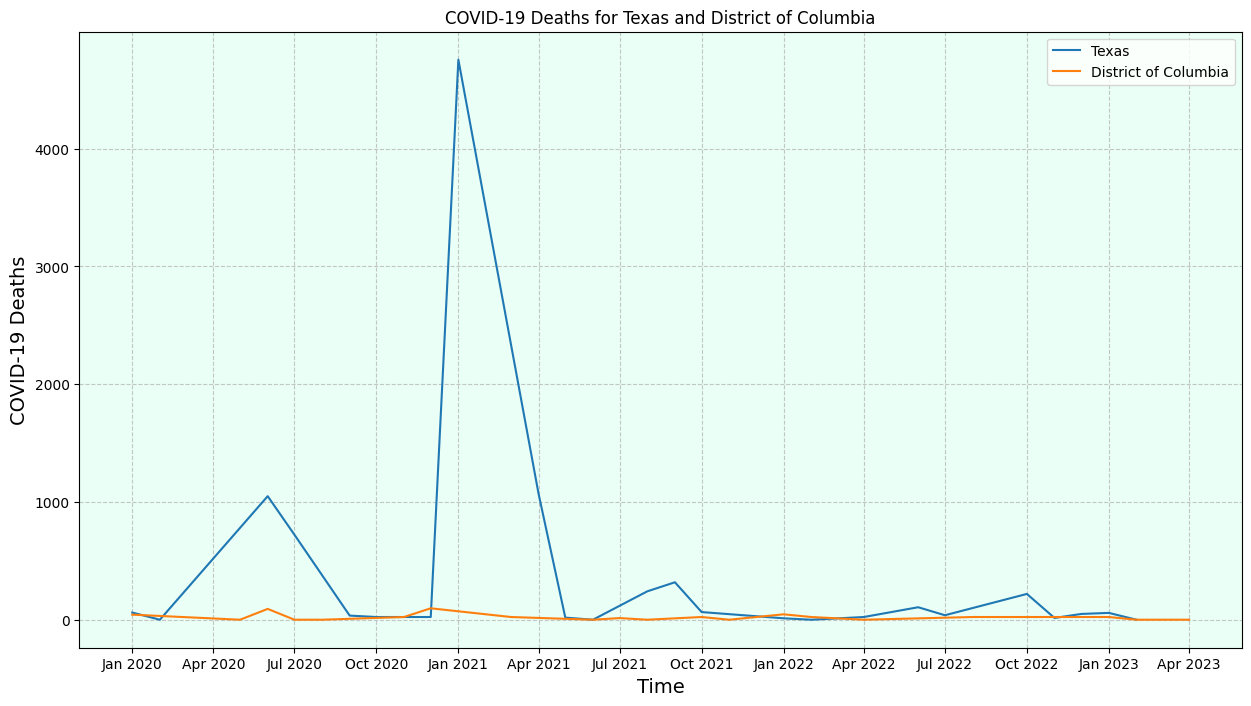

In [56]:
state1 = 'Texas'
state2 = 'District of Columbia'

filtered_df = df[(df['State']==state1) | (df['State']==state2)]
filtered_df['Start Date'] = pd.to_datetime(filtered_df['Start Date'])
grouped_df = filtered_df.groupby(['Start Date','State']).agg({'COVID-19 Deaths':'sum'}).reset_index()

fig,ax = plt.subplots(figsize=(15,8))
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_facecolor('#eafff5')
for state in [state1,state2]:
    state_data = grouped_df[grouped_df['State']==state]
    ax.plot(state_data['Start Date'], state_data['COVID-19 Deaths'], label=state)
    
ax.set_title(f'COVID-19 Deaths for {state1} and {state2}')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('COVID-19 Deaths', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))


ax.legend()
plt.show()

## One Hot Encoding

#### One Hot Encoding enables the conversion of categorical values to numerical for model creation.

#### Since One Hot Encoder converts all the different types of categorical features into a new column and represents it with 0 and 1's. The dimensions of the data increases substantially. 

In [57]:
encoded_df = pd.get_dummies(df, columns = ['State', 'Place of Death'])
print(f'There are {df.columns.nunique()} columns and {len(df)} rows in the original dataframe\n')
print(f'There are {encoded_df.columns.nunique()} columns and {len(encoded_df)} rows in the encoded dataframe')
encoded_df.head()

There are 13 columns and 1331 rows in the original dataframe

There are 73 columns and 1331 rows in the encoded dataframe


Start Date   End Date     Group  Year  Month  COVID-19 Deaths  Total Deaths  \
0 2020-01-01 2020-01-31  By Month  2020      1                0           314   
1 2020-01-01 2020-01-31  By Month  2020      1                0             0   
2 2020-01-01 2020-01-31  By Month  2020      1                0           230   
3 2020-01-01 2020-01-31  By Month  2020      1                0            18   
4 2020-01-01 2020-01-31  By Month  2020      1                0            34   

   Pneumonia Deaths  Pneumonia and COVID-19 Deaths  Influenza Deaths  ...  \
0                35                              0                 0  ...   
1                 0                              0                 0  ...   
2                11                              0                 0  ...   
3                 0                              0                 0  ...   
4                 0                              0                 0  ...   

   State_Wisconsin  State_Wyoming  Place of Death_Decedent's home  \
0                0              0                               0   
1                0              0                               0   
2                0              0                               0   
3                0              0                               0   
4                0              1                               0   

   Place of Death_Healthcare setting, dead on arrival  \
0                                                  0    
1                                                  1    
2                                                  0    
3                                                  0    
4                                                  0    

   Place of Death_Healthcare setting, inpatient  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Place of Death_Healthcare setting, outpatient or emergency room  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  1                 
4                                                  1                 

   Place of Death_Hospice facility  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   

   Place of Death_Nursing home/long term care facility  Place of Death_Other  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  1                       0   
3                                                  0                       0   
4                                                  0                       0   

   Place of Death_Place of death unknown  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0  

[5 rows x 73 columns]

# Model creation and Predictions

# 1.Linear Regression

### Train-Test split

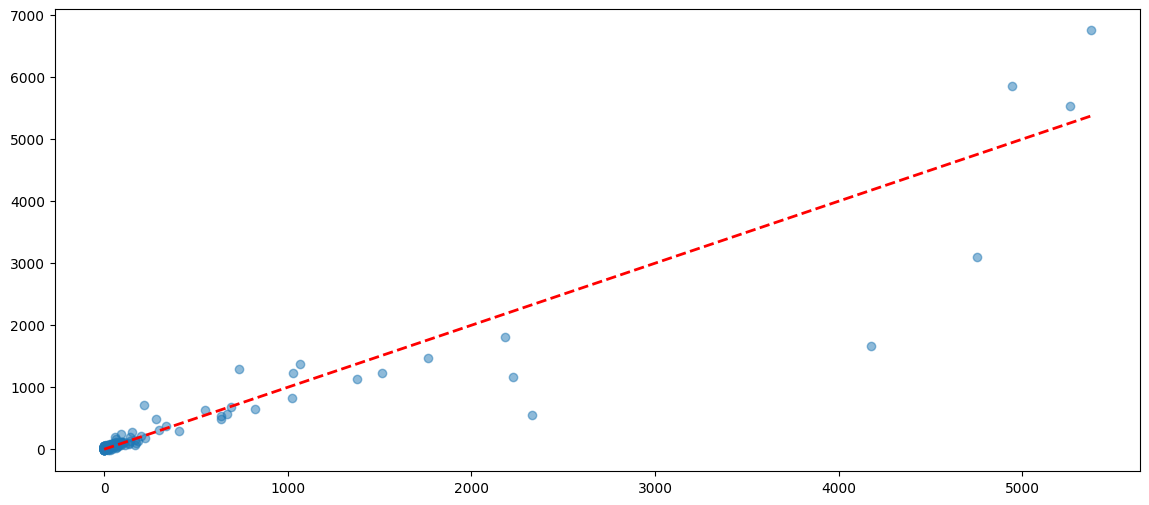

In [65]:
X = df[['Year', 'Month', 'Total Deaths', 'Pneumonia Deaths', 'Influenza Deaths']]
y = df['COVID-19 Deaths']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.show()

In [63]:
mse_val = mse(y_test, y_pred)

print(f"Mean Squared Error: {mse_val}")
print(f"R-Squared: {r2_score(y_test, y_pred)}")

Mean Squared Error: 65891.19561617576
R-Squared: 0.8751039725712706


# 2.Decision Tree

In [64]:
from sklearn.metrics import mean_squared_error as mse

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
mse_value = mse(y_test, y_pred)
print('Mean Squared Error:', mse_value)
print(f"R-Squared: {r2_score(y_test, y_pred)}")

Mean Squared Error: 74969.71017998336
R-Squared: 0.8578957493273283


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a DataFrame 'df' with the data
X = df[['Year', 'Month', 'Total Deaths', 'Pneumonia Deaths', 'Influenza Deaths']]
y = df['COVID-19 Deaths']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')


Mean Squared Error: 61698.83573609129
R-Squared: 0.8830505440316554


## Gradient Boosting Regressor

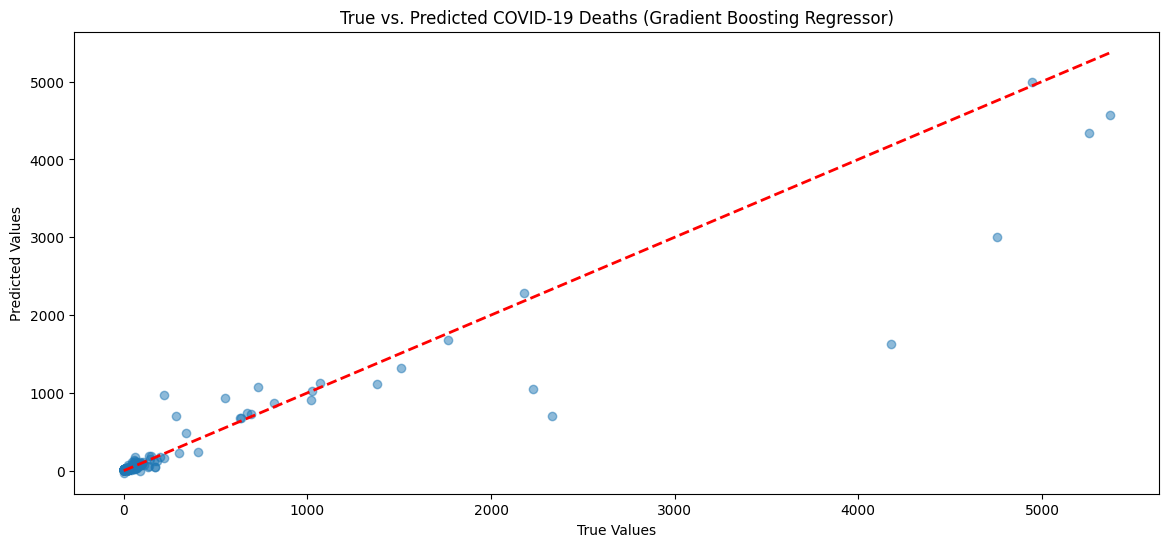

In [67]:
import matplotlib.pyplot as plt

# Scatter plot of true values vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted COVID-19 Deaths (Gradient Boosting Regressor)')

# Plot the perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)

# Show the plot
plt.show()
